# asmFoam Verification Case

This case compares solutions of the ASM1 biokinetics equations, solved as an ODE and using the `asmFOAM` CFD solver. The CFD case has no flow or diffusion, so the solution must be identical to the ODE solution.

In [1]:
# Define the ASM model constants

# Stoichiometry (all dimensionless)

YA  = 0.24;      # Heterotrophic yield
YH  = 0.67;      # Autotrophic yield
fP  = 0.08;      # Fraction of biomass yielding particulate products
iXB = 0.086;     # Mass of nitrogen per mass of COD in biomass
iXP = 0.06;      # Mass of nitrogen per mass of COD in products from biomass

# Kinetics parameters
muH   = 3.0;     # Max. specific growth rate for heterotrophic biomass [1/day]
KS    = 20;      # Half-saturation coefficient for heterotrophic biomass [g/m^3]
KOH   = 0.2;     # Oxygen half-saturation coefficient for heterotrophic biomass [g/m^3]
KNO   = 0.5;     # Nitrate half-saturation coefficient for denitrifying heterotrophic biomass [g/m^3]
bH    = 0.42;    # Decay coefficient for heterotrophic biomass [1/day]
etag  = 0.8;     # Correction factor for muH under anoxic conditions []
etah  = 0.4;     # Correction factor for hydrolysis under anoxic conditions []
kh    = 2.0;     # Maximum specific hydrolysis rate [1/day]
KX    = 0.02;    # Half-saturation coefficient for hydrolysis of slowly biodegradable substrate []
muA   = 0.5;     # Maximum specific growth rate for autotrophic biomass [1/day]
KNH   = 1;       # Ammonia half-saturation coefficient for autotrophic biomass [g/m^3]
KOA   = 0.4;     # Oxygen half-saturation coefficient for autotrophic biomass [g/m^3]
bA    = 0.42;    # Decay coefficient for autotrophic biomass [1/day]
ka    = 0.08;    # Ammonification rate [m^3/g/day]
kLa   = 210;     # Oxygen mass transfer coefficient [1/day] 
SOsat = 9.28;    # Oxygen saturation concentration [g/m^3]


In [3]:
import numpy as np
from scipy.integrate import ode

# Define the initial concentrations and state vector

SS0 = 580
XS0 = 360
XBH0 = 500
XBA0 = 50
XP0 = 40
SO0 = 0.5
SNO0 = 1
SNH0 = 60
SND0 = 6
XND0 = 15

x0 = np.array([SS0, XS0, XBH0, XBA0, XP0, SO0, SNO0, SNH0, SND0, XND0])

# Define ODE source terms
def f(t, x):
    # Get the state variables
    SS = x[0]
    XS = x[1]
    XBH = x[2]
    XBA = x[3]
    XP = x[4]
    SO = x[5]
    SNO = x[6]
    SNH = x[7]
    SND = x[8]
    XND = x[9]
    
    # Define the reaction rates
    rhoHeterotrophAerobicGrowth = muH * SS/(KS + SS) * SO/(KOH + SO) * XBH
    rhoHeterotrophAnoxicGrowth = muH * SS/(KS + SS) * KOH/(KOH + SO) * SNO/(KNO + SNO) \
                               * etag * XBH
    rhoAutotrophAerobicGrowth = muA * SNH/(KNH + SNH) * SO/(KOA + SO) * XBA
    rhoHeterotrophDecay = bH * XBH
    rhoAutotrophDecay = bA * XBA
    rhoAmmonification = ka * SND * XBH
    rhoOrganicHydrolysis = kh * XS/XBH/(KX + XS/XBH) * (SO/(KOH + SO) \
                         + etah * KOH/(KOH + SO) * SNO/(KNO + SNO)) * XBH
    rhoOrganicNitrogenHydrolysis = rhoOrganicHydrolysis * XND / XS
    
    # Define the source term
    src = np.zeros(10)
    src[0] = - rhoHeterotrophAerobicGrowth/YH \
             - rhoHeterotrophAnoxicGrowth/YH \
             + rhoOrganicHydrolysis
    src[1] = + (1-fP)*rhoHeterotrophDecay \
             + (1-fP)*rhoAutotrophDecay \
             - rhoOrganicHydrolysis
    src[2] = + rhoHeterotrophAerobicGrowth \
             + rhoHeterotrophAnoxicGrowth \
             - rhoHeterotrophDecay
    src[3] = + rhoAutotrophAerobicGrowth \
             - rhoAutotrophDecay
    src[4] = + fP*rhoHeterotrophDecay \
             + fP*rhoAutotrophDecay
    src[5] = - (1-YH)/YH*rhoHeterotrophAerobicGrowth \
             - (4.57-YA)/YA*rhoAutotrophAerobicGrowth \
             + kLa*(SOsat - SO)
    src[6] = - (1-YH)/2.86/YH*rhoHeterotrophAnoxicGrowth \
             + rhoAutotrophAerobicGrowth/YA
    src[7] = - iXB*rhoHeterotrophAerobicGrowth \
             - iXB*rhoHeterotrophAnoxicGrowth \
             - (iXB+1/YA)*rhoAutotrophAerobicGrowth \
             + rhoAmmonification
    src[8] = - rhoAmmonification \
             + rhoOrganicNitrogenHydrolysis
    src[9] = + (iXB-fP*iXP)*rhoHeterotrophDecay \
             + (iXB-fP*iXP)*rhoAutotrophDecay \
             - rhoOrganicNitrogenHydrolysis
    
    # Return the source term
    return src

# Set time information
dt = 0.001   # [days]
tStart = 0.0 # [days]
tEnd = 5.0   # [days]

# Set up the ODE integrator
r = ode(f)
r.set_initial_value(x0, tStart)

# Set up the lists for the results variables
time_ode= list()
SS_ode = list()
XS_ode = list()
XBH_ode = list()
XBA_ode = list()
XP_ode = list()
SO_ode = list()
SNO_ode = list()
SNH_ode = list()
SND_ode = list()
XND_ode = list()

# Solve ODE
while r.successful() and r.t < tEnd:
    r.integrate(r.t+dt)
    time_ode.append(r.t)
    SS_ode.append(r.y[0])
    XS_ode.append(r.y[1])
    XBH_ode.append(r.y[2])
    XBA_ode.append(r.y[3])
    XP_ode.append(r.y[4])
    SO_ode.append(r.y[5])
    SNO_ode.append(r.y[6])
    SNH_ode.append(r.y[7])
    SND_ode.append(r.y[8])
    XND_ode.append(r.y[9])

time_ode = np.array(time_ode)
SS_ode = np.array(SS_ode)
XS_ode = np.array(XS_ode)
XBH_ode = np.array(XBH_ode)
XBA_ode = np.array(XBA_ode)
XP_ode = np.array(XP_ode)
SO_ode = np.array(SO_ode)
SNO_ode = np.array(SNO_ode)
SNH_ode = np.array(SNH_ode)
SND_ode = np.array(SND_ode)
XND_ode = np.array(XND_ode)

In [5]:
# Read the CFD data

import csv
import numpy as np

# Create the data arrays
time = list()
SS = list()
XS = list()
XBH = list()
XBA = list()
XP = list()
SO = list()
SNO = list()
SNH = list()
SND = list()
XND = list()

# Open and read the data file
with open('postProcessing/asmFieldAverages/0/volFieldValue.dat') as csvfile:

    reader = csv.reader(csvfile, delimiter='\t')
    
    # Skip the header lines
    for _ in range(4):
        next(reader)
    
    # Read the data
    for row in reader:
        time.append(float(row[0]))
        SS.append(float(row[1]))
        XS.append(float(row[2]))
        XBH.append(float(row[3]))
        XBA.append(float(row[4]))
        XP.append(float(row[5]))
        SO.append(float(row[6]))
        SNO.append(float(row[7]))
        SNH.append(float(row[8]))
        SND.append(float(row[9]))
        XND.append(float(row[10]))
        
# Convert to numpy arrays
time = np.array(time)
SS = np.array(SS)
XS = np.array(XS)
XBH = np.array(XBH)
XBA = np.array(XBA)
XP = np.array(XP)
SO = np.array(SO)
SNO = np.array(SNO)
SNH = np.array(SNH)
SND = np.array(SND)
XND = np.array(XND)

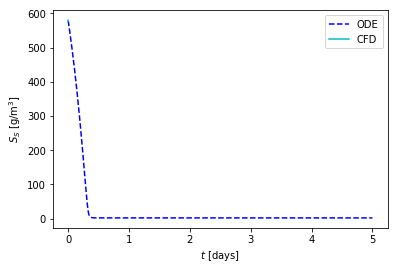

In [6]:
# Plot the readily biodegradable substrate (SS)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, SS_ode, 'b--', label='ODE')
plt.plot(time/86400, SS*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_S$ [g/m$^3$]')
plt.show()

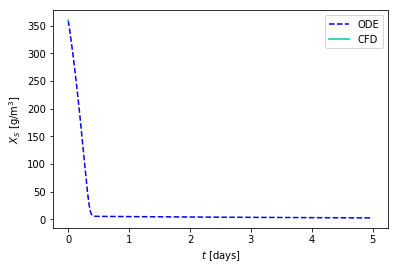

In [7]:
# Plot the slowly biodegradable substrate (XS)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, XS_ode, 'b--', label='ODE')
plt.plot(time/86400, XS*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_S$ [g/m$^3$]')
plt.show()

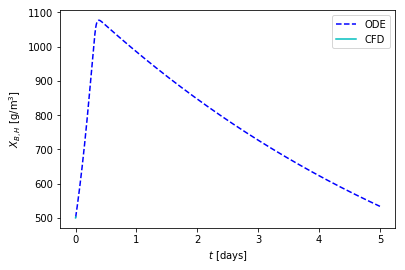

In [8]:
# Plot the active heterotrophic biomass (XBH)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, XBH_ode, 'b--', label='ODE')
plt.plot(time/86400, XBH*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_{B,H}$ [g/m$^3$]')
plt.show()

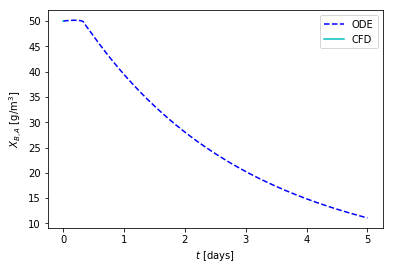

In [9]:
# Plot the active autotrophic biomass (XBA)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, XBA_ode, 'b--', label='ODE')
plt.plot(time/86400, XBA*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_{B,A}$ [g/m$^3$]')
plt.show()

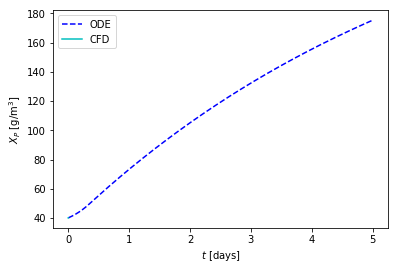

In [10]:
# Plot the particulate products arising from biomass decay (XP)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, XP_ode, 'b--', label='ODE')
plt.plot(time/86400, XP*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_P$ [g/m$^3$]')
plt.show()

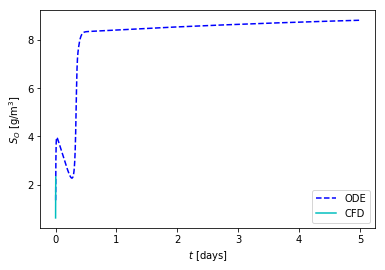

In [11]:
# Plot the oxygen (SO)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, SO_ode, 'b--', label='ODE')
plt.plot(time/86400, SO*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_O$ [g/m$^3$]')
plt.show()

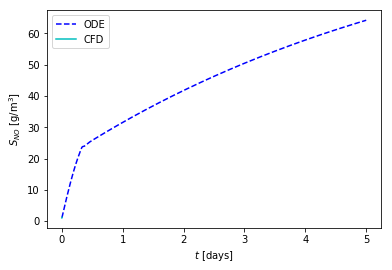

In [12]:
# Plot the nitrate and nitrite (SNO)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, SNO_ode, 'b--', label='ODE')
plt.plot(time/86400, SNO*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_{NO}$ [g/m$^3$]')
plt.show()

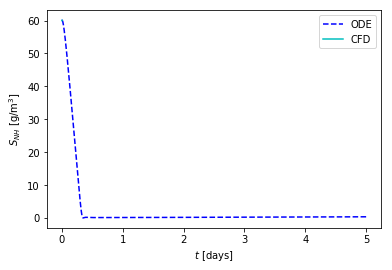

In [13]:
# Plot the ammonia and ammonium nitrogen (SNH)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, SNH_ode, 'b--', label='ODE')
plt.plot(time/86400, SNH*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_{NH}$ [g/m$^3$]')
plt.show()

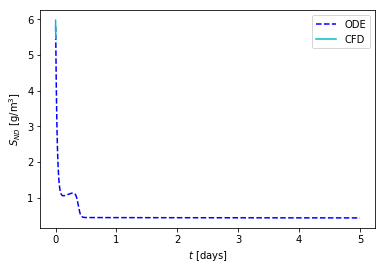

In [14]:
# Plot the soluble biodegradable organic nitrogen (SND)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, SND_ode, 'b--', label='ODE')
plt.plot(time/86400, SND*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_{ND}$ [g/m$^3$]')
plt.show()

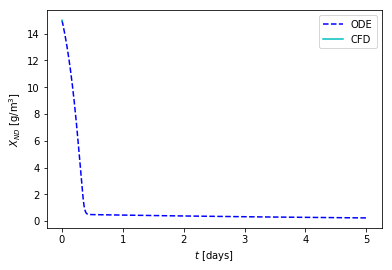

In [15]:
# Plot the particulate biodegradable organic nitrogen (XND)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ode, XND_ode, 'b--', label='ODE')
plt.plot(time/86400, XND*1000, 'c-', label='CFD')
plt.legend()
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_{ND}$ [g/m$^3$]')
plt.show()